In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 

pd.set_option('display.max.rows',169)
pd.set_option('display.max.columns',169)
pd.set_option('float_format', '{:.2f}'.format)

In [2]:
df = pd.read_csv('aug_train.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.92,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.00
1,29725,city_40,0.78,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.00
2,11561,city_21,0.62,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.00
3,33241,city_115,0.79,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.00
4,666,city_162,0.77,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.00


In [3]:
df.shape

(19158, 14)

In [4]:
df.info(verbose = True,null_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

/var/folders/1h/8jpwsyfx1qq9hn8hj0tpnjhw0000gn/T/ipykernel_8521/3066153830.py:1: FutureWarning: null_counts is deprecated. Use show_counts instead
  df.info(verbose = True,null_counts = True)


In [5]:
null_count = df.isnull().sum()
null_percentage = round((df.isnull().sum()/df.shape[0])*100, 2)
null_df = pd.DataFrame({'column_name' : df.columns,'null_count' : null_count,'null_percentage': null_percentage})
null_df.reset_index(drop = True, inplace = True)
null_df.sort_values(by = 'null_percentage', ascending = False)

,column_name,null_count,null_percentage
10,company_type,6140,32.05
9,company_size,5938,30.99
3,gender,4508,23.53
7,major_discipline,2813,14.68
6,education_level,460,2.40
11,last_new_job,423,2.21
5,enrolled_university,386,2.01
8,experience,65,0.34
0,enrollee_id,0,0.00
1,city,0,0.00


In [6]:
df.select_dtypes(include = "object").columns

Index(['city', 'gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'experience', 'company_size',
       'company_type', 'last_new_job'],
      dtype='object')

In [7]:
categ = df.select_dtypes(include = "object").columns.tolist()

In [8]:
df.select_dtypes(include=["int64","float64"]).columns

Index(['enrollee_id', 'city_development_index', 'training_hours', 'target'], dtype='object')

In [9]:
eliminar_columnas = null_df[null_df['null_percentage'] > 30].column_name.to_list()

In [10]:
df.drop(columns = eliminar_columnas, inplace = True)

In [11]:
categ = df.select_dtypes(include = "object").columns.tolist()

In [12]:
df.gender.fillna('Male', inplace=True)

In [13]:
df['major_discipline'].fillna('No Major', inplace=True)

In [14]:
df['education_level'].fillna('Other', inplace=True)

In [15]:
df['last_new_job'].fillna('never', inplace=True)

In [16]:
df['enrolled_university'].fillna('no_enrollment', inplace=True)

In [17]:
df['experience'].fillna(0, inplace=True)

In [18]:
from collections import Counter

#drop the label 
outlier_list = ['city_development_index', 'training_hours'] 

def detect_outlier(df,feature):
    
    outlier_indices = []
    
    for f in feature:
        
        #lower quartile
        q1 = np.percentile(df[f],25)
        
        #upper quartile
        q3 = np.percentile(df[f],75)
        
        #interquartile range
        iqr = q3-q1
        
        #with coefficient
        with_coef = 1.5*iqr
        
        #detect outlier(s)
        lower_rule = q1-with_coef
        upper_rule = q3+with_coef
        
        outlier_variable = df[(df[f]<lower_rule) | (df[f]>upper_rule)].index
        outlier_indices.extend(outlier_variable)
    
    #converting to amount
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i,v in outlier_indices.items() if v>2)
    
    return multiple_outliers

 
#drop outliers
df = df.drop(detect_outlier(df,outlier_list),axis=0).reset_index(drop=True)

In [19]:
def distributions(df, categ):
    plt.figure(figsize = (10,5))
    ax = sns.countplot(x = df[categ], hue=df.target, data = df)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/len(df[categ]))
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plt.annotate(percentage, (x, y),ha='center')
    plt.show()

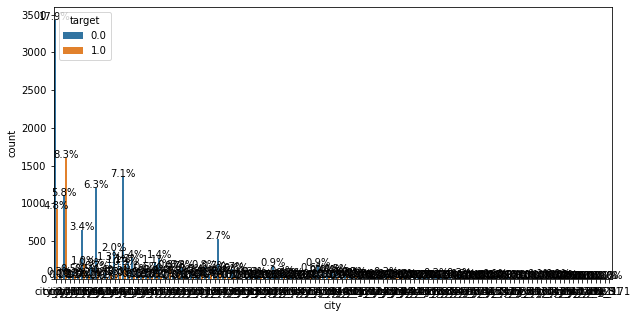

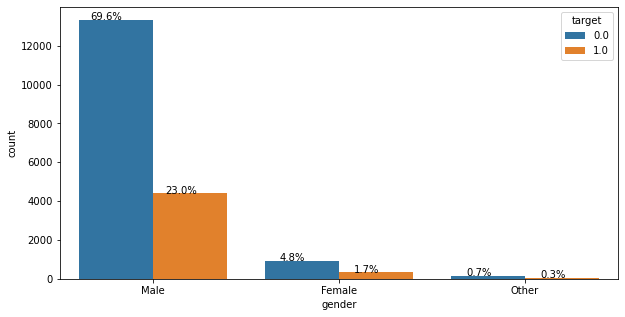

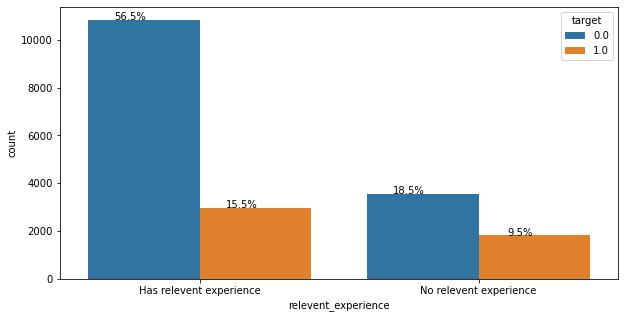

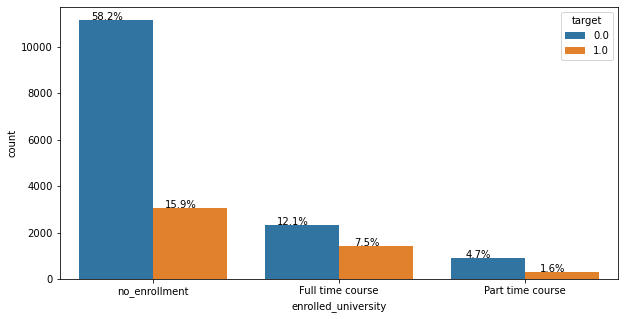

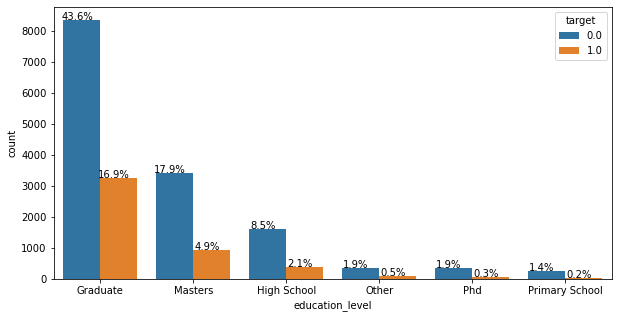

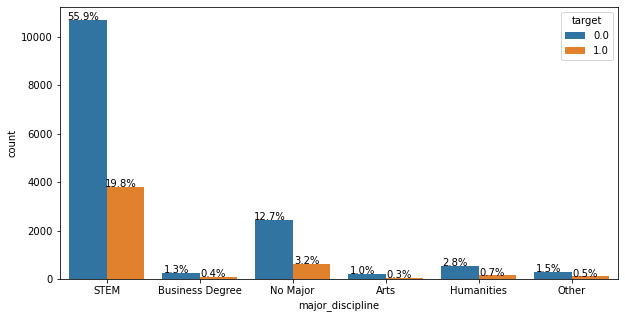

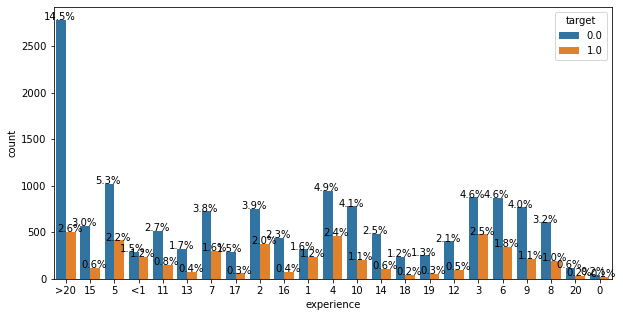

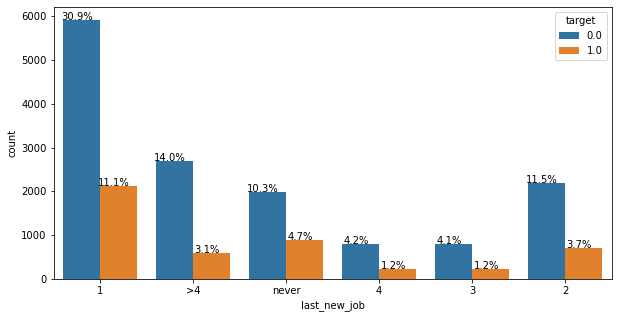

In [20]:
for i in categ:
    distributions(df,i)
    plt.show()

In [21]:
encoder = LabelEncoder()

In [22]:
df['gender']=encoder.fit_transform(df['gender'])

In [23]:
df['relevent_experience'] = encoder.fit_transform(df['relevent_experience'])

In [24]:
df['enrolled_university'] = encoder.fit_transform(df['enrolled_university'])

In [25]:
df['education_level'] = encoder.fit_transform(df['education_level'])

In [26]:
df['major_discipline'] =encoder.fit_transform(df['major_discipline'])

In [27]:
df['experience'].replace({'>20':21, '<1':0}, inplace=True)

In [28]:
df['experience']=df['experience'].astype('int')

In [29]:
df["last_new_job"].replace({">4": "5","never":"0"}, inplace=True)

In [30]:
df["last_new_job"]=df["last_new_job"].astype('int')

In [31]:
df.drop(['enrollee_id','city'], axis=1, inplace=True)

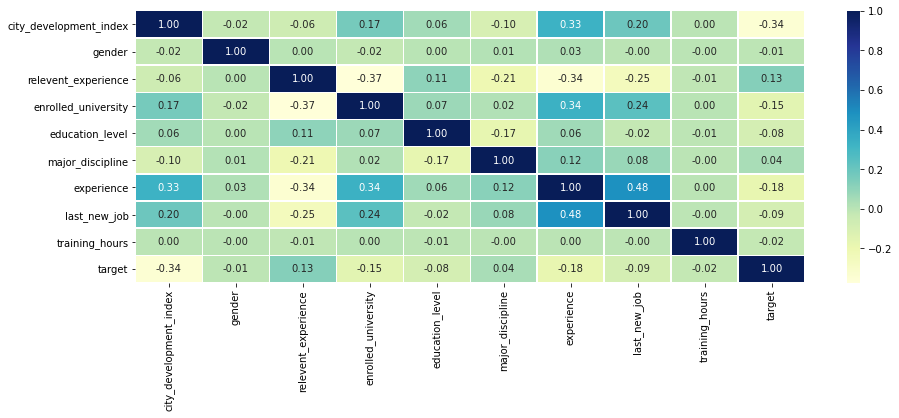

In [32]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu", linewidths=.5,fmt='.2f')
plt.show()

In [33]:
X = df.drop(['target'], axis = 1)
y = df['target']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1, stratify=df['target'])

In [35]:
y_train.value_counts()

0.00    11504
1.00     3822
Name: target, dtype: int64

In [36]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [37]:
y_res.value_counts()

0.00    11504
1.00    11504
Name: target, dtype: int64

In [38]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier

In [39]:
pipelines = {
    'rf': make_pipeline(RandomForestClassifier(random_state=42)),
    'gb': make_pipeline(GradientBoostingClassifier(random_state=42)),
    'l1': make_pipeline(StandardScaler(), LogisticRegression(penalty='l1', random_state= 1,solver='liblinear')),
    'l2': make_pipeline(StandardScaler(), LogisticRegression(penalty='l2', random_state= 1,solver='liblinear')),
    'dt': make_pipeline(DecisionTreeClassifier(random_state=42)),
    'knn': make_pipeline(StandardScaler(), KNeighborsClassifier()),
    'svc':make_pipeline(StandardScaler(),SVC(random_state=42))
}

In [40]:
for key, value in pipelines.items():
    print(key, type(value))

rf <class 'sklearn.pipeline.Pipeline'>
gb <class 'sklearn.pipeline.Pipeline'>
l1 <class 'sklearn.pipeline.Pipeline'>
l2 <class 'sklearn.pipeline.Pipeline'>
dt <class 'sklearn.pipeline.Pipeline'>
knn <class 'sklearn.pipeline.Pipeline'>
svc <class 'sklearn.pipeline.Pipeline'>


In [41]:
rf_hyperparameters = {
    'randomforestclassifier__criterion':['entropy','gini'],
    'randomforestclassifier__n_estimators': [100, 200, 300],
    'randomforestclassifier__max_features': ['auto', 0.3, 0.6],
    'randomforestclassifier__min_samples_split':[2,3,10],
    'randomforestclassifier__min_samples_leaf':[1,3,10],
    'randomforestclassifier__bootstrap':[True, False]
}

gb_hyperparameters = {
    'gradientboostingclassifier__n_estimators':[100, 500, 100],
    'gradientboostingclassifier__learning_rate': [0.001,0.01,0.1,0.05],
    'gradientboostingclassifier__max_depth':[3, 5, 10]
}

l1_hyperparameters = {
    'logisticregression__C': np.logspace(-3,3,7)
}
l2_hyperparameters = {
    'logisticregression__C': np.logspace(-3,3,7)
}
dt_hyperparameters = {
    "decisiontreeclassifier__max_depth" : [1,3,5,7],
    'decisiontreeclassifier__criterion':['entropy','gini'],
    'decisiontreeclassifier__splitter':['best']
}

knn_hyperparameters = {
    "kneighborsclassifier__n_neighbors": np.arange(1,50),
    "kneighborsclassifier__weights": ["uniform","distance"]
}
svc_hyperparameters = {
    'svc__C': [1.0,], 
    'svc__kernel': ['rbf',], 
    'svc__degree': [2,], 
    'svc__gamma' : [1.0,], 
    'svc__shrinking':[True,], 
    'svc__probability':[True,],
    'svc__tol': [0.001,],
    'svc__cache_size':[200,]
}


In [42]:
hyperparameter_grids = {
    'rf': rf_hyperparameters,
    'gb': gb_hyperparameters,
    'l1':l1_hyperparameters,
    'l2':l2_hyperparameters,
    'dt':dt_hyperparameters,
    'knn': knn_hyperparameters,
    'svc':svc_hyperparameters
}

In [43]:
for key in ['rf', 'gb', 'l1', 'l2', 'dt', 'knn', 'svc']:
    if key in hyperparameter_grids:
        if type(hyperparameter_grids[key]) is dict:
            print( key, 'was found, and it is a grid.' )
        else:
            print( key, 'was found, but it is not a grid.' )
    else:
        print( key, 'was not found')

rf was found, and it is a grid.
gb was found, and it is a grid.
l1 was found, and it is a grid.
l2 was found, and it is a grid.
dt was found, and it is a grid.
knn was found, and it is a grid.
svc was found, and it is a grid.


In [44]:
models = {}

for key in pipelines.keys():
    models[key]= GridSearchCV(pipelines[key], hyperparameter_grids[key], cv=10, scoring = 'roc_auc',
                             n_jobs= -1,
                             verbose = 1)
    
models.keys()

dict_keys(['rf', 'gb', 'l1', 'l2', 'dt', 'knn', 'svc'])

In [45]:
best_estimators = []

for key in models.keys():
    clf = models[key].fit(X_res,y_res)
    best_estimators.append(clf.best_estimator_)
    print(key, "is trained and tuned")
    print('Method: {} Best: {}' .format(key,clf.best_estimator_))

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
rf is trained and tuned
Method: rf Best: Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_features=0.6,
                                        min_samples_split=10, n_estimators=300,
                                        random_state=42))])
Fitting 10 folds for each of 36 candidates, totalling 360 fits
gb is trained and tuned
Method: gb Best: Pipeline(steps=[('gradientboostingclassifier',
                 GradientBoostingClassifier(learning_rate=0.05, max_depth=10,
                                            n_estimators=500,
                                            random_state=42))])
Fitting 10 folds for each of 7 candidates, totalling 70 fits
l1 is trained and tuned
Method: l1 Best: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(C=1000.0, penalty='l1', random_state=1,
      

In [46]:
from sklearn.metrics import accuracy_score, auc, f1_score, precision_score, recall_score,\
                            roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix

In [53]:
for key in models.keys() :
    pred = models[key].predict(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, pred)
    print(key)
    print("Score del modelo (accuracy):", round(models[key].score(X_test, y_test), 3))
    print("Accuracy score:", round(accuracy_score(pred, y_test), 3))
    print("Recall score:", round(recall_score(pred, y_test), 3))
    print("Precision score:", round(precision_score(pred, y_test), 3))
    print("F1 score:", round(f1_score(pred, y_test), 3))
    print('AUROC =', round(auc(fpr, tpr), 4))
    print("AUC:", round(roc_auc_score(pred, y_test), 3))
    print('---')

rf
Score del modelo (accuracy): 0.708
Accuracy score: 0.728
Recall score: 0.457
Precision score: 0.488
F1 score: 0.472
AUROC = 0.6477
AUC: 0.641
---
gb
Score del modelo (accuracy): 0.701
Accuracy score: 0.74
Recall score: 0.474
Precision score: 0.406
F1 score: 0.437
AUROC = 0.6282
AUC: 0.643
---
l1
Score del modelo (accuracy): 0.701
Accuracy score: 0.701
Recall score: 0.428
Precision score: 0.59
F1 score: 0.496
AUROC = 0.6639
AUC: 0.636
---
l2
Score del modelo (accuracy): 0.701
Accuracy score: 0.701
Recall score: 0.428
Precision score: 0.59
F1 score: 0.496
AUROC = 0.6639
AUC: 0.636
---
dt
Score del modelo (accuracy): 0.709
Accuracy score: 0.71
Recall score: 0.439
Precision score: 0.579
F1 score: 0.499
AUROC = 0.6665
AUC: 0.641
---
knn
Score del modelo (accuracy): 0.686
Accuracy score: 0.688
Recall score: 0.411
Precision score: 0.581
F1 score: 0.481
AUROC = 0.6522
AUC: 0.625
---
svc
Score del modelo (accuracy): 0.689
Accuracy score: 0.698
Recall score: 0.423
Precision score: 0.583
F1 sc

In [48]:
voting_c = VotingClassifier(estimators=[('rf',best_estimators[0]),
                                        ('gb',best_estimators[1]),
                                        ('l1',best_estimators[2]),
                                        ('l2',best_estimators[3]),
                                        ('dt',best_estimators[4]),
                                        ('knn', best_estimators[5]),
                                        ('svc', best_estimators[6])
                                       ],
                           voting='soft',
                           n_jobs=-1)

In [49]:
voting_c = voting_c.fit(X_res,y_res)
print("Score del modelo (accuracy):", round(voting_c.score(X_test, y_test), 3))
print("Accuracy score:", round(accuracy_score(voting_c.predict(X_test), y_test), 3))
print("Recall score:", round(recall_score(voting_c.predict(X_test), y_test), 3))
print("Precision score:", round(precision_score(voting_c.predict(X_test), y_test), 3))
print("F1 score:", round(f1_score(voting_c.predict(X_test), y_test), 3))
print("AUC:", round(roc_auc_score(voting_c.predict(X_test), y_test), 3))

Score del modelo (accuracy): 0.731
Accuracy score: 0.731
Recall score: 0.468
Precision score: 0.559
F1 score: 0.509
AUC: 0.656


<AxesSubplot:>

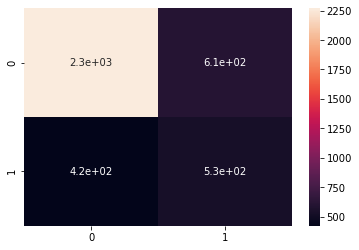

In [50]:
c_matrix = confusion_matrix(y_test, voting_c.predict(X_test))
sns.heatmap(c_matrix, annot=True)

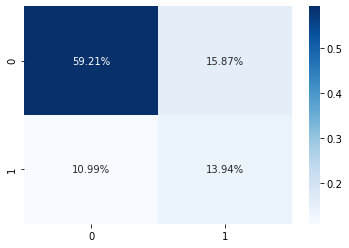

In [51]:
sns.heatmap(c_matrix/np.sum(c_matrix), annot=True, 
            fmt='.2%', cmap='Blues');